In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True

In [2]:
import os

# path = 'C:\\Users\\qcrew\\Desktop\\EPR\\pyEPR'
# os.chdir(path)
os.getcwd()
# !python -m pip install -e .

'C:\\Users\\qcrew\\Desktop\\EPR\\A-pyEPR'

# pyEPR Startup Example
##### Single transmon qubit mode analysis  
Author: Zlatko Minev

## <div style="background:#BBFABB;line-height:2em;">Load pyEPR<div>

In [3]:
import pyEPR as epr

This loads the `pyEPR` package under the shorthand name `epr`.

We can access the main different submodules, like this:
  * `epr.calcs`  : calculations tools 
  * `epr.ansys`  : tools for controlling ansys hfss, q3d, etc.
  * `epr.toolbox`: useful and handly toolbox for plotting, pythonic manipulations, etc. 
  * `epr.core`  : The core module of analysis functions. This does not need ot be accessed by the user typically. It essentually provides the main two classes: ProjectInfo, DistributedAnalysis, and QuantumAnalysis -- which represent the different stages of the simulation. Let us examine these next. 
  
EPR also has some handy functions, which we will explore:

In [4]:
print('Parsing unis:  1um =', 
      epr.parse_entry('1um', 'meters'), 'meters')

print(f"""For   L_J = 11 nH, the Josephson junction energy is
      E_J = {epr.calcs.Convert.Ej_from_Lj(11, 'nH', 'GHz'):.1f} GHz""")

Parsing unis:  1um = 1e-06 meters
For   L_J = 11 nH, the Josephson junction energy is
      E_J = 14.9 GHz


#### Load Ansys HFSS tutorial file  

Let us first determine where the example file is stored.
For tutorial, let us get the path to the tutorial folder.

In [5]:
# Load Path temporarily just to find where the tutorial folder is
# return path_to_project
from pathlib import Path
# path_to_project = Path(epr.__file__).parent.parent / '_example_files'
path_to_project = Path(epr.__file__).parent.parent.parent / 'A-pyEPR'
print(f'We will the example project located in\n {path_to_project}')

We will the example project located in
 c:\users\qcrew\desktop\epr\A-pyEPR


## <div style="background:#BBFABB;line-height:2em;">Connect to Ansys HFSS<div>

Now, we will open Ansys Desktop and connect to a specific project.

You can use the following creation keyword arguments to specify which design to look at 

 * `project_path`: 
    Directory path to the hfss project file. Should be the directory, not the file.
    default = None: Assumes the project is open, and thus gets the project based on `project_name`
 * `project_name`:
    Name of the project within the project_path. "None" will get the current active one.
 * `design_name` :
    Name of the design within the project. "None" will get the current active one.
 * `setup_name`  :
    Name of the setup within the design. "None" will get the current active one.

Use `?epr.ProjectInfo` to see all the arguments

In [6]:
pinfo = epr.ProjectInfo(project_path = path_to_project, 
                         project_name = '1transmon_0910',
                         design_name  = 'side')

# pinfo = epr.ProjectInfo(project_path = path_to_project, 
#                          project_name = 'pyEPR_tutorial1',
#                          design_name  = '1. single_transmon')

INFO 11:30AM [connect]: Connecting to Ansys Desktop API...
INFO 11:30AM [load_ansys_project]: 	File path to HFSS project found.
INFO 11:30AM [load_ansys_project]: 	Opened Ansys App
INFO 11:30AM [load_ansys_project]: 	Opened Ansys Desktop v2020.1.0
INFO 11:30AM [load_ansys_project]: 	Opened Ansys Project
	Folder:    c:/users/qcrew/desktop/epr/A-pyEPR/
	Project:   1transmon_0910
INFO 11:30AM [connect]: 	Opened active design
	Design:    side [Solution type: Eigenmode]
INFO 11:30AM [get_setup]: 	Opened setup `Setup1`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 11:30AM [connect]: 	Connection to Ansys established successfully. 😀 



Let's see what the design type was using the `design` object

In [7]:
# pinfo.disconnect()

In [8]:
pinfo.check_connected()

True

In [9]:
pinfo.design.solution_type

'Eigenmode'

Let us see what all the object in the design are. `pinfo` contains a function to retrieve these for convenience.

In [10]:
pinfo.get_all_object_names()

['enclosure',
 'port',
 'port_1',
 'subtrate',
 'sheet',
 'rect_jj',
 'sheet_1',
 'line_jj']

Let's see what variables there are in the design. 

In [11]:
pinfo.get_all_variables_names()

['rad_port',
 'length',
 'height',
 'c_l',
 'c_h',
 'depth',
 'width',
 'c_w',
 'pad_gap',
 'pad_h',
 'pad_w',
 'jj_w',
 'Ljj_1']

We can also get the names of the setups

In [12]:
pinfo.design.get_setup_names()

('Setup1',)

We can also get information such as mesh statistic and convergence (if you have already solved the model)

In [13]:
pinfo.setup.get_mesh_stats()

,Unnamed: 0,Num Tets,Min edge length,Max edge length,RMS edge length,Min tet vol,Max tet vol,Mean tet vol,Std Devn (vol)
0,enclosure,28962,0.010430,3.833590,1.362700,5.454680e-08,1.999700,0.133652,0.158168
1,port,282,0.461660,2.701630,1.202130,4.440610e-04,0.139593,0.015380,0.020228
2,port_1,295,0.382683,2.716940,1.204360,1.516290e-04,0.127982,0.014702,0.016155
3,subtrate,4370,0.011364,0.755524,0.331363,3.832470e-08,0.017660,0.001858,0.002517


We can also see how many modes we solved for

In [14]:
pinfo.setup.n_modes

'2'

##  <div style="background:#BBFABB;line-height:2em;"> Josephson tunnel junctions (non-linear elemetns) </div>

To analysze the quantum part of the model, let us specify the junctions in the model. 

The junciton is defined as described in the paper and on the landing page of pyEPR. There is a rectangle sheet inductance and a polyline that defines the current and voltage on the sheet.  

Let us call the single junction `j1`. A junction has the following properties:

  1. **Lj_variable** : Name of HFSS variable that specifies junction inductance Lj defined on the boundary condition in HFSS
  2. **rect**        : Name of HFSS rectangle on which lumped boundary condition is specified.
  3. **line**        : Name of HFSS polyline which spans the length of the recntalge. Used to define the voltage across the junction. 
  4. **Cj_variable** : (Optional) Name of HFSS variable that specifies junction lumped capacitance Cj defined on the boundary condition in HFSS. This is optional.

In [29]:
pinfo.junctions['j1'] = {'Lj_variable' : 'Ljj_1', 
                         'rect'        : 'rect_jj', 
                         'line'        : 'line_jj', 
                         'length'      : epr.parse_units('100um')}


# Check that valid names of variables and objects have been supplied.
# An error is raised with a message if something is wrong.
pinfo.validate_junction_info()  

## <div style="background:#BBFABB;line-height:2em;">Micrwoave Analysis: <br>Run analysis on an eigenmode solution  <div>

Assumeing we have field solutions saved for the HFSS *eigenmode* design, we can now create the analysis object from the 
calss `DistributedAnalysis`.

**Run analysis:** (Tutorial action) Run the analysis in the design model. 
This can be done manually, or using pyEPR.

In [64]:
# Calling this function will run an analysis of the design in the background. 
# The console will wait for HFSS to complete.
# pinfo.design.delete_full_variation()
pinfo.setup.analyze()

INFO 03:38PM [analyze]: Analyzing setup Setup1


**Run optimetrics**

The following will get the frequencies and Qs from HFSS. 

In [65]:
# Calling this function will run an analysis on all the optimetrics  the design in the background. 
# The console will wait for HFSS to complete.
# This requires optimetrics license by HFSS. 

pinfo.design.optimetrics.get_setup_names()
pinfo.design.optimetrics.solve_setup(pinfo.design.optimetrics.get_setup_names()[0])

**EPR Analysis object**

Let us introduce the core analysis object of `pyEPR`, which will be a class instance of `epr.DistributedAnalysis`. This is how we will run most of our analysis.

Let us recover the eigenmode frequencies of the first variation we ran, which is indexed by '0'.

In [66]:
# This is the core object for interacting with HFSS
# and running analysis within HFSS.
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 

Design "side" info:
	# eigenmodes    2
	# variations    8


In [67]:
eprh.get_ansys_variables()

variation,0,1,2,3,4,5,6,7
c_h,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm,0.40000000000000002mm
c_l,7mm,7mm,7mm,7mm,7mm,7mm,7mm,7mm
c_w,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm,2.8999999999999999mm
depth,0mm,0mm,0mm,0mm,0mm,0mm,0mm,0mm
height,17mm,17mm,17mm,17mm,17mm,17mm,17mm,17mm
jj_w,50um,50um,50um,50um,50um,50um,50um,50um
length,33mm,33mm,33mm,33mm,33mm,33mm,33mm,33mm
Ljj_1,12nH,5nH,6nH,7nH,8nH,9nH,10nH,11nH
pad_gap,100um,100um,100um,100um,100um,100um,100um,100um
pad_h,350um,350um,350um,350um,350um,350um,350um,350um


In [68]:
eprh.get_ansys_frequencies_all()

Freq. (GHz)  Quality Factor
variation mode                             
0         0        4.302482    7.598336e+13
          1        9.239573    3.472885e+07
1         0        6.872461    4.794814e+11
          1        9.282202    6.072688e+06
2         0        6.197483    9.345532e+12
          1        9.266220    1.489041e+07
3         0        5.834047    6.108446e+12
          1        9.260113    1.276941e+07
4         0        5.383024    3.897117e+13
          1        9.253134    4.303137e+06
5         0        5.142741    3.823741e+13
          1        9.250975    2.983429e+07
6         0        4.878314    5.410737e+13
          1        9.248654    2.573918e+07
7         0        4.531328    1.119855e+14
          1        9.243867    2.333786e+07

In [69]:
eprh.get_mesh_statistics()

,Unnamed: 0,Num Tets,Min edge length,Max edge length,RMS edge length,Min tet vol,Max tet vol,Mean tet vol,Std Devn (vol)
0,enclosure,39220,0.012473,3.833590,1.227850,4.328890e-08,2.107670,0.098695,0.120879
1,port,294,0.461660,2.701630,1.195760,4.623750e-04,0.139593,0.014752,0.018323
2,port_1,299,0.382683,2.716940,1.210880,1.516290e-04,0.127982,0.014505,0.016500
3,subtrate,5575,0.011201,0.828025,0.300263,4.229950e-08,0.024167,0.001456,0.001964


INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 0
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


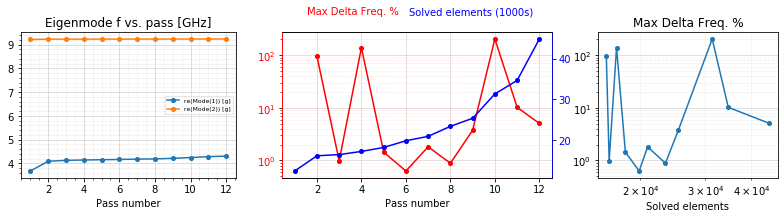

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 1
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


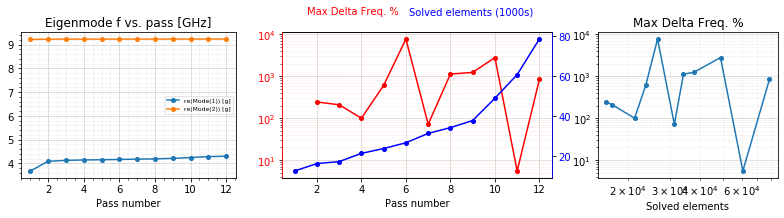

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 2
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


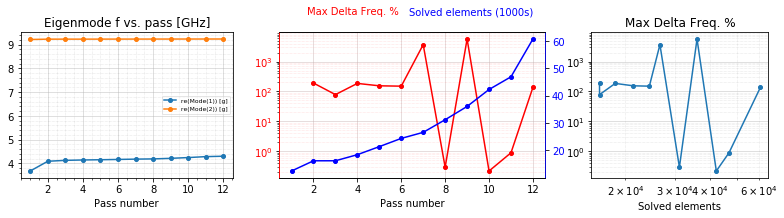

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 3
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


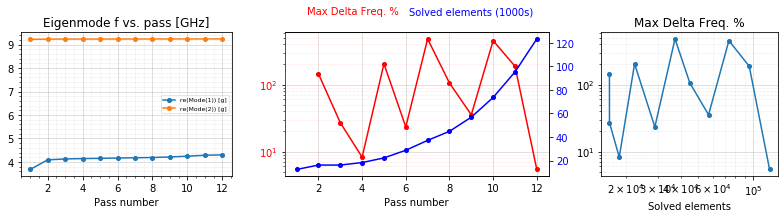

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 4
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


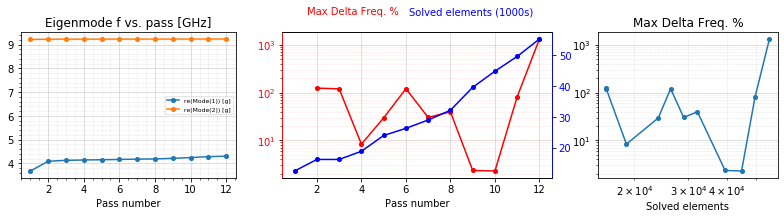

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 5
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


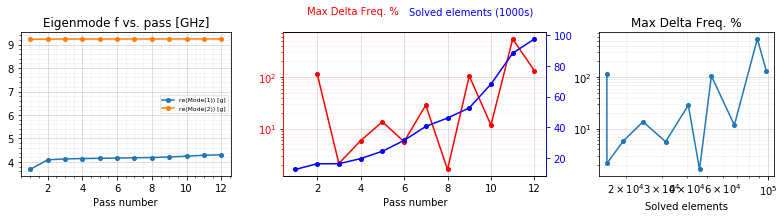

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 6
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


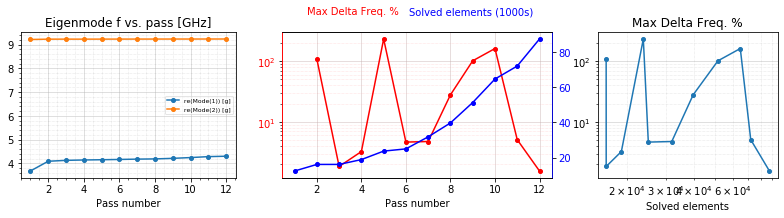

INFO 04:07PM [hfss_report_full_convergence]: Creating report for variation 7
INFO 04:07PM [hfss_report_f_convergence]: Saved convergences to D:\data-pyEPR\1transmon_0910\side\hfss_eig_f_convergence.csv


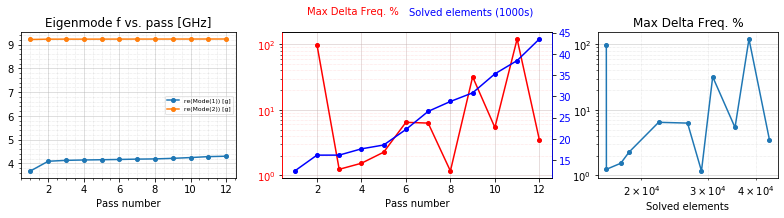

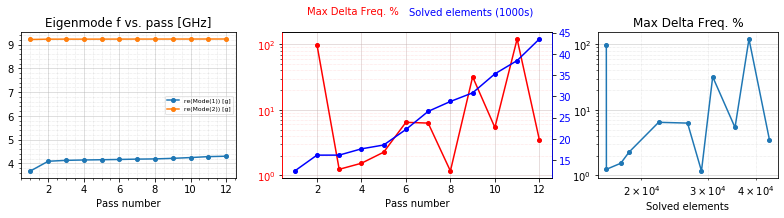

In [70]:
eprh.hfss_report_full_convergence();

We can see that the convergence wasn't actually terrific, though we only used 60,000 tets. However, there seems to be a divergence above 15 passes in this example. We will probably need to change our mesh operations to create a monotonic convergence.

However, for the purpose of the tutorial, let us press forward. 

You can use these autogenerated reports to keep track of your simulations.
This is still all at the clasical level. Take a look at the other methods, including
 * `hfss_report_full_convergence`
 * `hfss_report_f_convergence`
 * `get_convergence`
 * `get_mesh_statistics`
 * `get_freqs_bare_pd`
 * ...
 
For example, you can get tables of the freqs and Qs using 
```python
Fs, Qs = eprh.get_freqs_bare_pd(variation='0')
```

In [71]:
import pandas as pd
# for variation in eprh.variations:
for variation in eprh.variations[:2]: # just for the first 2
    Fs, Qs = eprh.get_freqs_bare_pd(variation=variation, frame=False)
    display(pd.DataFrame({'Freq. (GHz)':Fs, 'Quality Factor':Qs}))

,Freq. (GHz),Quality Factor
0,4.302482,7.598336e+13
1,9.239573,3.472885e+07


,Freq. (GHz),Quality Factor
0,6.872461,4.794814e+11
1,9.282202,6.072688e+06


The Q is infinite, since we have not included dissipation yet in this example. The row index is the mode number

####  Full analysis

Let's now jump ahead to the full analysis.

In [72]:
# Do EPR analysis for all modes and all variations 
# If you want to only analze a certain variation, you can change the 
# default keyword argeumetns variations=None, modes=None
eprh.do_EPR_analysis();


Variation 0  [1/8]

  Mode 0 at 4.30 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.1%  3.817e-23 7.348e-25

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.28%
	j1              0.979413  (+)        0.0171781
		(U_tot_cap-U_tot_ind)/mean=0.92%

  Mode 1 at 9.24 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.3%  2.701e-21 2.693e-21

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 92.52%
	j1              0.00312329  (+)        0.000252631
		(U_tot_cap-U_tot_ind)/mean=0.02%

Variation 1  [2/8]

  Mode 0 at 6.87 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E  

##### Getting more info

In [8]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is 4473-AB45

 Directory of C:\Users\qcrew\Desktop\EPR\A-pyEPR

09/15/2020  09:19 AM    <DIR>          .
09/15/2020  09:19 AM    <DIR>          ..
09/10/2020  12:43 PM    <DIR>          .ipynb_checkpoints
09/12/2020  03:26 PM           643,761 1transmon_0910.aedt
09/15/2020  09:13 AM               871 1transmon_0910.aedt.lock
09/15/2020  09:13 AM    <DIR>          1transmon_0910.aedtresults
09/15/2020  09:19 AM           570,361 1transmon_epr.ipynb
               3 File(s)      1,214,993 bytes
               4 Dir(s)  682,210,877,440 bytes free


In [20]:
from numpy import load

data = load("D:\\data-pyEPR\\1transmon_0910\\side_noport\\2020-09-12 14-35-24.npz", allow_pickle=True)
# lst = data.files
# for item in lst:
#     print(item)
#     print(data[item])

data

{'project_info': {'pinfo': design_name                             side_noport
  project_name                         1transmon_0910
  project_path    c:/users/qcrew/desktop/epr/A-pyEPR/
  setup_name                                   Setup1
  dtype: object,
  'dissip': dielectrics_bulk       None
  dielectric_surfaces    None
  resistive_surfaces     None
  seams                  None
  dtype: object,
  'options': Series([], dtype: float64),
  'junctions':                   j1
  Lj_variable    Ljj_1
  length        0.0001
  line         line_jj
  rect         rect_jj,
  'ports': Empty DataFrame
  Columns: []
  Index: []},
 'results': AttrDict({'1': AttrDict({'Pm':          j1
 0  0.917524
 1  0.021226, 'Pm_cap':          j1
 0  0.016572
 1  0.000722, 'Sm':    s_j1
 0     1
 1     1, 'Om':                  0         1
 freq_GHz  6.763993  9.281965, 'sols':             U_H           U_E
 0  3.235838e-24  5.030330e-23
 1  1.166134e-21  1.191652e-21, 'Qm_coupling': Empty DataFrame
 Columns

In general, to see more info when running commands , set the logger level

In [ ]:
import logging
epr.logger.setLevel(logging.DEBUG)

## <div style="background:#BBFABB;line-height:2em;"> Quantum Hamiltonian Analysis:<br> Load mw-analysis results and perform hamiltonian analysis on the solutions  <div>

We will now postprocess the mw analysis to obtain the quantum Hamiltonian. 

The code object of postprocessing is `epra`, an instance of `epr.QuantumAnalysis`.

	 Differences in variations:


variation,1,0,2,3,4,5,6,7
_Ljj_1,5nH,12nH,6nH,7nH,8nH,9nH,10nH,11nH





 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 1

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.020274
1    1.021520
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    5nH
Name: 1, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.917524
1  0.021226

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.94
     0.021

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       153     9.54
      9.54    0.148

*** Chi matrix ND (MHz) 
       164      8.4
       8.4    0.117

*** Frequencies O1 PT (MHz)
0    6605.924056
1    9277.046903
dtype: float64

*** Frequencies ND (MHz)
0    6601.779613
1    9277.233302
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019624
1    1.053525
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    12nH
Name: 0, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.961454
1  0.003208

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0032

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       167     2.32
      2.32  0.00807

*** Chi matrix ND (MHz) 
       185     2.38
      2.38  0.00751

*** Frequencies O1 PT (MHz)
0    4186.859026
1    9242.453715
dtype: float64

*** Frequencies ND (MHz)
0    4179.655692
1    9242.426708
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 2

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.020169
1    1.025297
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    6nH
Name: 2, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.932618
1  0.013042

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.95
     0.013

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       159     6.54
      6.54    0.067

*** Chi matrix ND (MHz) 
       171     5.95
      5.95   0.0556

*** Frequencies O1 PT (MHz)
0    6033.795479
1    9264.559155
dtype: float64

*** Frequencies ND (MHz)
0    6029.142977
1    9264.643927
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 3

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019873
1    1.031271
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    7nH
Name: 3, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.942567
1  0.008899

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.96
    0.0089

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       161     4.83
      4.83   0.0363

*** Chi matrix ND (MHz) 
       173     4.51
      4.51   0.0312

*** Frequencies O1 PT (MHz)
0    5534.810821
1    9256.203317
dtype: float64

*** Frequencies ND (MHz)
0    5529.771145
1    9256.240426
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 4

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019556
1    1.035031
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    8nH
Name: 4, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.949047
1  0.006663

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0067

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       161     3.87
      3.87   0.0233

*** Chi matrix ND (MHz) 
       175     3.69
      3.69   0.0205

*** Frequencies O1 PT (MHz)
0    5144.234991
1    9251.050677
dtype: float64

*** Frequencies ND (MHz)
0    5138.800192
1    9251.064568
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 5

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019817
1    1.036595
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    9nH
Name: 5, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.953720
1  0.005157

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.97
    0.0052

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       165     3.22
      3.22   0.0157

*** Chi matrix ND (MHz) 
       180     3.11
      3.11   0.0134

*** Frequencies O1 PT (MHz)
0    4872.675486
1    9249.129640
dtype: float64

*** Frequencies ND (MHz)
0    4866.658704
1    9249.131068
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 6

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019516
1    1.047509
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    10nH
Name: 6, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.956842
1  0.004376

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0044

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       164     2.86
      2.86   0.0125

*** Chi matrix ND (MHz) 
       179     2.82
      2.82   0.0113

*** Frequencies O1 PT (MHz)
0    4575.928718
1    9245.224524
dtype: float64

*** Frequencies ND (MHz)
0    4569.656402
1    9245.214207
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 7

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.019543
1    1.046657
dtype: float64

Pm_norm idx =
      j1
0   True
1  False

*** Different parameters


_Ljj_1    11nH
Name: 7, dtype: object



*** P (participation matrix, not normlz.)
         j1
0  0.959516
1  0.003691

*** S (sign-bit matrix)
   s_j1
0     1
1     1
*** P (participation matrix, normalized.)
      0.98
    0.0037

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       166     2.55
      2.55   0.0098

*** Chi matrix ND (MHz) 
       183     2.56
      2.56  0.00896

*** Frequencies O1 PT (MHz)
0    4374.396704
1    9244.082261
dtype: float64

*** Frequencies ND (MHz)
0    4367.620333
1    9244.063815
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


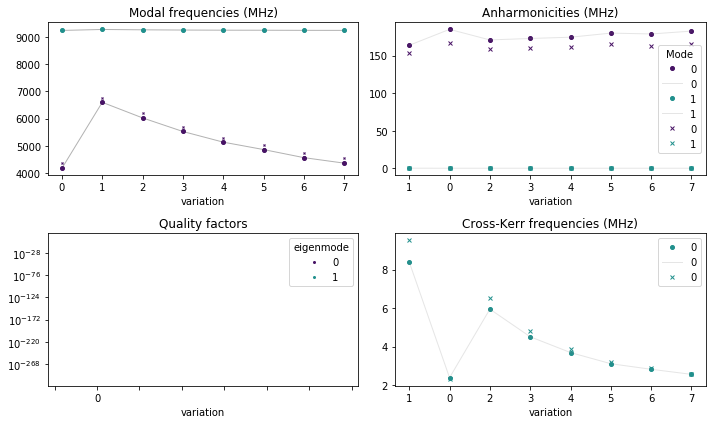

In [54]:
%matplotlib inline
# plot the figures in the notebook. 

# This is the core object for working with post processing data from HFSS
# This iwll load the saved solutions from above
epra = epr.QuantumAnalysis(eprh.data_filename)

# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15)
epra.plot_hamiltonian_results();

## <div style="background:#BBFABB;line-height:2em;"> Swept variable analysis driven thorugh pyEPR:<br> Sweep variable in hfss, analyze microwaves, then analyze quantum<div>

Let us now run a more complicated example, where we will sweep $L_j$. This demonstrates some of the `pyEPR` funcationality. 

**Classical microwave, distributed analysis**

Sweep variable in HFSS, run circuits

In [ ]:
import numpy as np 

### Configure setup
### Set the maximum number of passes on the analysis and a few other
pinfo.setup.passes = 15
pinfo.setup.min_freq = '3.2GHz'
pinfo.setup.modes = 2 
pinfo.setup.delta_f = 0.02 
pinfo.setup.basis_order = epr.ansys.BASIS_ORDER['Mixed Order']


### What to sweep 
# Define sweep variables to go over
swp_var = 'Lj_1' # name
# how to convert sweep param to string variable in nanoHeries. 
to_swp_val = lambda x: f'{x}nH' 

### Run Sweep 
for swp_param in np.linspace(6, 12, 6):
    swp_val = to_swp_val(swp_param)
    epr.logger.info(f'Setting sweep variable {swp_var}={swp_val}')
    pinfo.design.set_variable(swp_var, swp_val)
    pinfo.setup.analyze()

**EPR mw analysis**

Classical-to-quantum bridge. 

In [ ]:
eprh = epr.DistributedAnalysis(pinfo) # epr hfss analysis 
eprh.hfss_report_full_convergence()

In [ ]:
# Do EPR analysis for all modes and all variations 
eprh.do_EPR_analysis();

**Quantum analysis** 

Perform the analysis and plot the results.

In [ ]:
# This is the core object for working with post processing data from HFSS
# This will load the saved solutions from above
epra = epr.QuantumAnalysis(eprh.data_filename)

In [ ]:
# Analyze 
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 15);

In [ ]:
#Custom sort of columns
def do_sort_index(df:pd.DataFrame):
    if isinstance(df, pd.DataFrame):
        df.columns = df.columns.astype(float)
        return df.sort_index(axis=1)
    else:
        return df

epra.results.do_sort_index = do_sort_index
df = epra.results.get_frequencies_HFSS(vs='Lj_1')
df

In [ ]:
epra.results.sort_index = True
epra.plot_hamiltonian_results(sweep_variable='Lj_1');

There is some jitter, since we have have run some of the runs to only a few passes here.

Please see Part II of the tutorial to continue. You will find it in the tutorial folder as a jupyter notebook. 

In [ ]:
epra.quick_plot_mode(0,0,1,numeric=True,swp_variable='Lj')

In [ ]:
epra.report_results(swp_variable=swp_variable, numeric=True)

# <div style="background:#BBFABB;line-height:2em;"> Addendum: <br> Snippets for ease <div>

An easy way to define many junctions is the following, using python3 f-strings for ease:

In [ ]:
# Specify multiple junctions in HFSS model
n_junctions = 5
for i in range(1, 1+n_junctions):
    pinfo.junctions[f'j{i}'] = {'Lj_variable' : f'Lj{i}',
                                'rect'        : f'JJrect{i}',
                                'line'        : f'JJline{i}',
                                'length'      : parse_units('100um')}

**NEXT:** Please see *Part II* of the tutorial to continue. You will find it in the tutorial folder as a jupyter notebook. 